In [1]:
### paper: https://arxiv.org/pdf/1511.06434.pdf ###

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [2]:
class Discriminator(nn.Module):
    def __init__(self, image_channels, discriminator_features):
        super().__init__()
        self.discriminator = nn.Sequential(
            # Input: N x image_channels x 64 x 64
            nn.Conv2d(image_channels, discriminator_features, kernel_size=4, stride=2, padding=1), # 32 x 32
            nn.LeakyReLU(0.2),
            self._block(discriminator_features, discriminator_features*2, kernel_size=4, stride=2, padding=1), # 16 x 16
            self._block(discriminator_features*2, discriminator_features*4, kernel_size=4, stride=2, padding=1), # 8 x 8
            self._block(discriminator_features*4, discriminator_features*8, kernel_size=4, stride=2, padding=1), # 4 x 4
            nn.Conv2d(discriminator_features*8, 1, kernel_size=4, stride=2, padding=0), # 1 x 1
            nn.Sigmoid(),
            
        )
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                    in_channels,
                    out_channels, 
                    kernel_size, 
                    stride,
                    padding,
                    bias=False
                    ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )
        
    def forward(self, inputs):
        return self.discriminator(inputs)

In [3]:
class Generator(nn.Module):
    def __init__(self, noise_dim, image_channels, generator_features):
        super().__init__()
        self.generator = nn.Sequential(
            # Input: N x noise_dim x 1 x 1
            self._block(noise_dim, generator_features*16, kernel_size=4, stride=1, padding=0), # N x gen_features x 4 x 4
            self._block(generator_features*16, generator_features*8, kernel_size=4, stride=2, padding=1), # 8 x 8
            self._block(generator_features*8, generator_features*4, kernel_size=4, stride=2, padding=1), # 16 x 16
            self._block(generator_features*4, generator_features*2, kernel_size=4, stride=2, padding=1), # 32 x 32
            nn.ConvTranspose2d( # No batch norm according to DCGAN paper
                generator_features*2,
                image_channels,
                kernel_size=4,
                stride=2,
                padding=1
            ), # 64 x 64
            nn.Tanh(),
        )
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        
    def forward(self, inputs):
        return self.generator(inputs)

In [4]:
def initialize_weights(model):
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(module.weight.data, 0.0, 0.02)

In [5]:
def test():
    batch_size, in_channels, H, W = 8, 3, 64, 64
    noise_dim = 100
    inputs = torch.randn((batch_size, in_channels, H, W))
    
    test_discriminator = Discriminator(in_channels, 8)
    initialize_weights(test_discriminator)
    
    assert test_discriminator(inputs).shape == (batch_size, 1, 1, 1), "Discriminator test failed"
    
    test_generator = Generator(noise_dim, in_channels, 8)
    initialize_weights(test_generator)
    
    assert test_generator(torch.randn((batch_size, noise_dim, 1, 1))).shape == (batch_size, in_channels, H, W), "Generator test failed"
    print("Tests passed")
    
test()

Tests passed


In [6]:
# ----- Hyperparameters ----- #
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 2e-4
batch_size = 128
image_size = 64
image_channels = 3 # 1 for mnist 3 for celebA
noise_dim = 100
epochs = 5

# discriminator_features and generator_features should be same to match paper
discriminator_features = 64
generator_features = 64

In [7]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5 for _ in range(image_channels)], [0.5 for _ in range(image_channels)]) # flexible normalization for dif channels
])

In [8]:
#dataset = datasets.MNIST(root="dataset/MNIST/", train=True, transform=transform, download=True)
dataset = datasets.ImageFolder(root="celeb_dataset/", transform=transform)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [9]:
# ----- Initialize models, optimizers, loss ----- #

generator = Generator(noise_dim, image_channels, generator_features).to(device)
discriminator = Discriminator(image_channels, discriminator_features).to(device)

initialize_weights(generator)
initialize_weights(discriminator)

generator_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999)) # 0.5 from paper
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

generator.train()
discriminator.train()

loss = nn.BCELoss() # standard loss for GANs

fixed_noise = torch.randn((32, noise_dim, 1, 1)).to(device) # 32 images to see how generator is doing

# ---- Tensorboard ----- #

writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

In [10]:
#generator = torch.load("generator.pth")
#discriminator = torch.load("discriminator.pth")

In [ ]:
for epoch in range(epochs):
    for batch_index, (real_images, _) in enumerate(loader):
        real_images = real_images.to(device)
        
        noise_input = torch.randn((batch_size, noise_dim, 1, 1)).to(device)
        
        # ----- Train Discriminator: min log(1 - D(x)) + log(D(G(z))) <-> log(1 - D(x)) = prob reals are fake, log(D(G(z))) = prob fakes are real----- #
        discriminator_on_reals = discriminator(real_images).reshape(-1) # N x 1 x 1 x 1 -> N
        loss_discriminator_on_reals = loss(discriminator_on_reals, torch.ones_like(discriminator_on_reals)) # ones for real images
        
        discriminator_on_fakes = discriminator(generator(noise_input)).reshape(-1) # N x 1 x 1 x 1 -> N
        loss_discriminator_on_fakes = loss(discriminator_on_fakes, torch.zeros_like(discriminator_on_fakes)) # zeros for fake images
        
        loss_discriminator = (loss_discriminator_on_fakes + loss_discriminator_on_reals)/2
        
        discriminator.zero_grad()
        loss_discriminator.backward(retain_graph=True)
        discriminator_optimizer.step()
        
        # ----- Train Generator: min log(1 - D(G(z))) = probs fakes are fake----- #
        
        generator_on_fakes = discriminator(generator(noise_input)).reshape(-1) # N x 1 x 1 x 1 -> N
        loss_generator = loss(generator_on_fakes, torch.ones_like(generator_on_fakes)) # ones for fake images
        
        generator.zero_grad()
        loss_generator.backward()
        generator_optimizer.step()
        
        # ----- Tensorboard ----- #
        
        if batch_index % 100 == 0:
            print(f"Epoch [{epoch}/{epochs}]\tLoss D: {loss_discriminator:.4f}\tLoss G: {loss_generator:.4f}")
            
            with torch.no_grad():
                
                fakes = generator(fixed_noise)
                real_images = real_images
                
                image_grid_of_reals = torchvision.utils.make_grid(real_images[:32], normalize=True)
                image_grid_of_fakes = torchvision.utils.make_grid(generator(fixed_noise), normalize=True)
                
                writer_real.add_image("Real Images", image_grid_of_reals, global_step=step)
                writer_fake.add_image("Fake Images", image_grid_of_fakes, global_step=step)
                
                step += 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


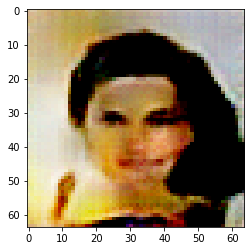

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


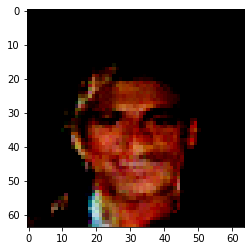

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


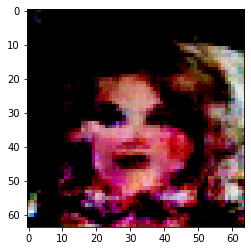

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


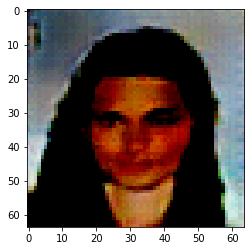

In [25]:
import matplotlib.pyplot as plt

noise = torch.randn((4, 100, 1, 1)).to(device)
generated_images = generator(noise)
for image in generated_images:
    plt.imshow(image.permute(1, 2, 0).cpu().detach().numpy())
    plt.show()

In [ ]:
torch.save(generator, "generator.pth")
torch.save(discriminator, "discriminator.pth")